In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sqlite3
import scrapbook as sb

plt.tight_layout()
plt.style.use('ggplot')

%matplotlib inline

D:\Anaconda3\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def ret_vol_mmd(df, lookback=10):
    o = df['open']
    h = df['high']
    l = df['low']
    c = df['close']
    
    # calculate return
    ret = c.pct_change()
    ret.rename('return', inplace=True)
    
    # calculate volatility
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    vol = np.sqrt(open_vol + k * close_vol + (1-k) * window_rs) * np.sqrt(252)
    vol.rename('volatility', inplace=True)
    
    # calculate maximum drawdown
    values = (1 + ret).cumprod()
    previous_peaks = values.cummax()
    mmd = (values - previous_peaks) / previous_peaks
    mmd.rename('maximumDrawdown', inplace=True)
    
    return pd.concat([ret, vol, mmd], axis=1)

In [3]:
def plot_series(data, ax):
    data.plot(ax=ax)
    
    starts = data.at_time('00:00:00').index.to_list()
    ends = starts[1:] + [data.index[-1]]
    colors = cm.rainbow(np.linspace(0, 1, len(starts)))
    
    for start, end, color in zip(starts, ends, colors):
        ax.axvspan(start, end, color=color, alpha=0.1)

In [4]:
token = 'AAVE'
start_date = '2021-11-01'
end_date = '2021-12-15'

In [5]:
# Parameters
start_date = "2021-11-29"
end_date = "2021-12-13"
token = "COMP"


In [6]:
df = pd.read_sql(f'''
SELECT
    *
FROM
    ohlc
WHERE
    token = '{token}'
    AND ts >= '{start_date}'
    AND ts < '{end_date}'
''', 'sqlite:///data/data.db')

df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)

In [7]:
df[['return', 'volatility', 'maximumDrawdown']] = ret_vol_mmd(df)

In [8]:
%%capture

fig, ax = plt.subplots(2, 2, figsize=(18, 18))

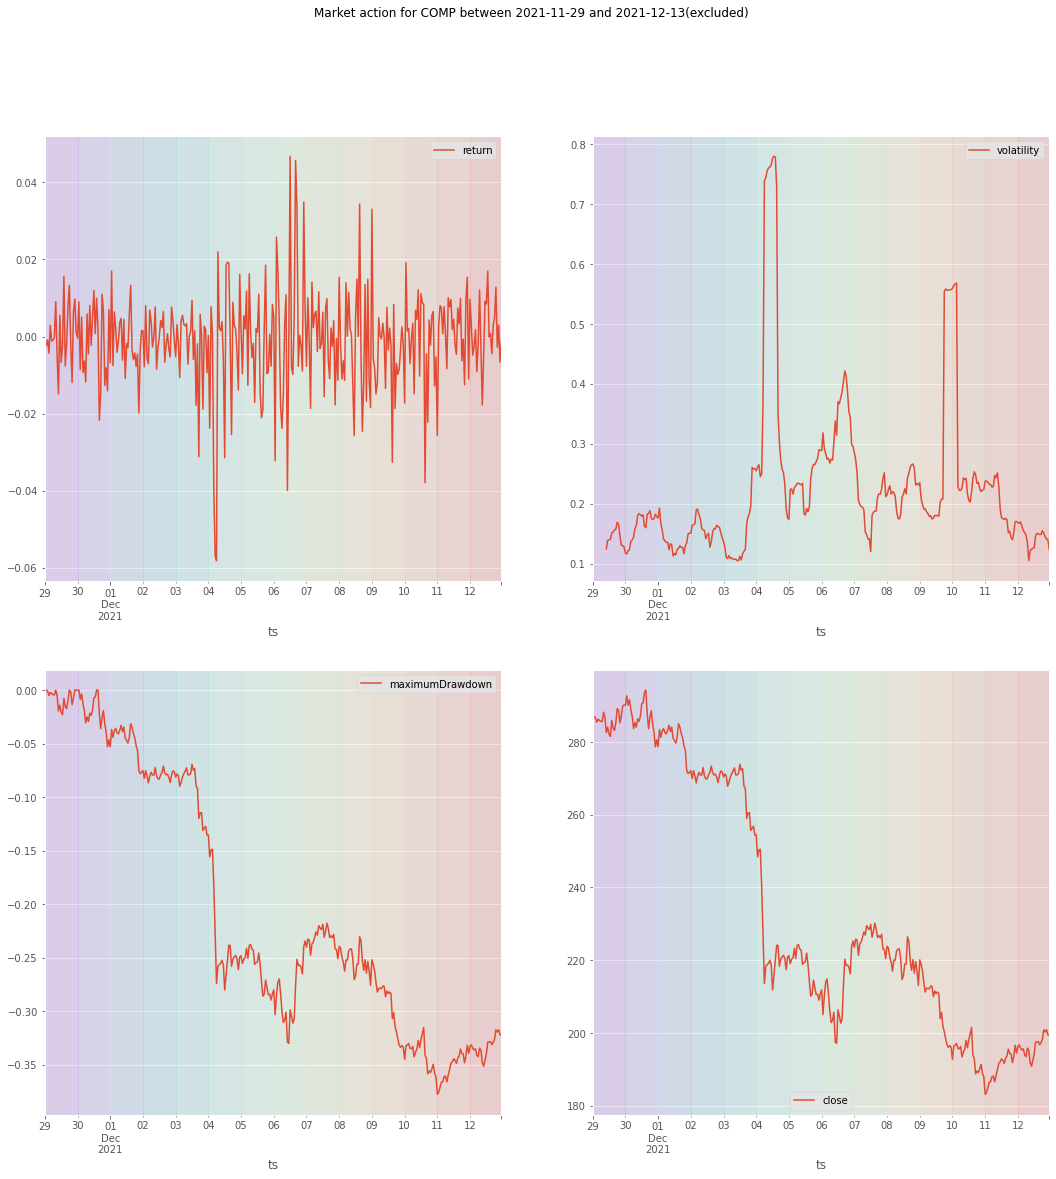

In [9]:
plot_series(df[['return']], ax=ax[0, 0])
plot_series(df[['volatility']], ax=ax[0, 1])
plot_series(df[['maximumDrawdown']], ax=ax[1, 0])
plot_series(df[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {start_date} and {end_date}(excluded)')
fig

In [10]:
sb.glue('token', token)
sb.glue('start_date', start_date)
sb.glue('end_date', end_date)
sb.glue('df', df, encoder='pandas')